In [1]:
# Install required packages
!pip install kaggle datasketch scikit-learn faiss-cpu langdetect tqdm
# For NLTK (if used):
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 52.7 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=4e443af60bac5c75fadcc9d41dd15bb541811d743dc053f5ae30a636cd6c80d5
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = "ersultan040403"
os.environ['KAGGLE_KEY'] = "c74b77ebd443fb863a7fa423c3e592d5"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -n amazon-books-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 96% 1.02G/1.06G [00:07<00:00, 108MB/s]
100% 1.06G/1.06G [00:07<00:00, 150MB/s]
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [3]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

USE_SAMPLE = True
NROWS_SAMPLE = 10000
JACCARD_THRESHOLD = 0.8
COSINE_THRESHOLD = 0.85


In [5]:
df_test = pd.read_csv(csv_path, nrows=1)
print(df_test.columns)

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


In [6]:
csv_path = 'Books_rating.csv'

df = pd.read_csv(
    csv_path,
    usecols=['review/text', 'review/summary', 'User_id', 'Title'],
    nrows=NROWS_SAMPLE if USE_SAMPLE else None
)

df['full_text'] = (df['review/summary'].fillna('') + ' ' + df['review/text'].fillna('')).str.strip()

df = df[df['full_text'].str.strip().astype(bool)]

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

tqdm.pandas()
df = df[df['full_text'].progress_apply(is_english)]
df = df.reset_index(drop=True)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return set(tokens)

tqdm.pandas()
df['tokens'] = df['full_text'].progress_apply(preprocess)

print(df[['full_text', 'tokens']].head(3))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  0%|          | 0/9955 [00:00<?, ?it/s]

                                           full_text  \
0  Nice collection of Julie Strain images This is...   
1  Really Enjoyed It I don't care much for Dr. Se...   
2  Essential for every personal and Public Librar...   

                                              tokens  
0  {worth, content, julie, olivia, photo, everyth...  
1  {diego, including, hesitate, picture, metamopr...  
2  {personal, guarde, imparting, secular, chapter...  


In [8]:
from itertools import combinations
from tqdm.notebook import tqdm

sample_n = min(1000, len(df))

jaccard_pairs = []

for i, j in tqdm(combinations(range(sample_n), 2), total=(sample_n*(sample_n-1))//2):
    tokens_i = df.iloc[i]['tokens']
    tokens_j = df.iloc[j]['tokens']
    if tokens_i and tokens_j:
        intersection = len(tokens_i & tokens_j)
        union = len(tokens_i | tokens_j)
        if union > 0:
            score = intersection / union
            if score >= JACCARD_THRESHOLD:
                jaccard_pairs.append((i, j, score))

print(f"Found {len(jaccard_pairs)} pairs with Jaccard similarity >= {JACCARD_THRESHOLD}")

for i, j, score in sorted(jaccard_pairs, key=lambda x: -x[2])[:5]:
    print("="*40)
    print(f"Review 1 (index {i}):\n{df.iloc[i]['full_text']}\n")
    print(f"Review 2 (index {j}):\n{df.iloc[j]['full_text']}\n")
    print(f"Jaccard similarity: {score:.3f}")


  0%|          | 0/499500 [00:00<?, ?it/s]

Found 13 pairs with Jaccard similarity >= 0.8
Review 1 (index 253):
Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how a little kid who lived in poverty with his mother goes on to become a six foot eight inch 245 pound high school basketball superstar. Lebron has to deal with the pressure of the media and go against tough opponents almost every game. Somehow he is able to handle all of this and all the other obstacles in his life. This is an entertaining book to read and I reccommend it to anyone who is a fan of Lebron James or is interested in reading about the rising star. The author does a great job of telling how Lebron is on and off the court. After reading this book you will come to respect Lebron as a basketbal player and a person.

Review 2 (index 256):
Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how

In [9]:
from datasketch import MinHash, MinHashLSH

NUM_PERM = 128
lsh = MinHashLSH(threshold=JACCARD_THRESHOLD, num_perm=NUM_PERM)

def get_minhash(token_set, num_perm=NUM_PERM):
    m = MinHash(num_perm=num_perm)
    for token in token_set:
        m.update(token.encode('utf8'))
    return m

minhashes = []
for tokens in tqdm(df['tokens'], desc='MinHash signatures'):
    minhashes.append(get_minhash(tokens))

for idx, mh in tqdm(enumerate(minhashes), total=len(minhashes), desc='LSH insert'):
    lsh.insert(str(idx), mh)

similar_pairs = set()
for idx, mh in tqdm(enumerate(minhashes), total=len(minhashes), desc='LSH query'):
    candidates = lsh.query(mh)
    for cand in candidates:
        j = int(cand)
        if idx < j:
            tokens_i = df.iloc[idx]['tokens']
            tokens_j = df.iloc[j]['tokens']
            jac = len(tokens_i & tokens_j) / len(tokens_i | tokens_j) if (tokens_i and tokens_j) else 0
            if jac >= JACCARD_THRESHOLD:
                similar_pairs.add((idx, j, jac))

print(f"Найдено {len(similar_pairs)} пар с Jaccard >= {JACCARD_THRESHOLD}")

for i, j, score in sorted(similar_pairs, key=lambda x: -x[2])[:5]:
    print("="*40)
    print(f"Review 1 (index {i}):\n{df.iloc[i]['full_text']}\n")
    print(f"Review 2 (index {j}):\n{df.iloc[j]['full_text']}\n")
    print(f"Jaccard similarity: {score:.3f}")


MinHash signatures:   0%|          | 0/9955 [00:00<?, ?it/s]

LSH insert:   0%|          | 0/9955 [00:00<?, ?it/s]

LSH query:   0%|          | 0/9955 [00:00<?, ?it/s]

Найдено 214 пар с Jaccard >= 0.8
Review 1 (index 5341):
John Carter finally returns to Barsoom to find Dejah Thoris At the end of &quot;A Princess of Mars,&quot; the first in the John Carter series by Edgar Rice Burroughs, John Carter got the factory that produced oxygen for Barsoom (the Martian name for Mars) working again, but had collapsed. When he revived he found himself back on earth, separated from Dejah Thoris, the Princess of Helium and his beloved. Originally published in 1913 as a serial in &quot;All-Story Magazine,&quot; this story finds John Carter returning to Mars and setting off to find his woman. Knowing that it was originally published as a serial is useful because Burroughs loads on the cliffhangers throughout the novel. When Carter returns to Barsoom a decade has passed and he finds himself in that part of the planet that the natives consider to be &quot;heaven,&quot; which proves to be a more ironic idea. Carter has to reunite with his friend the fierce green warri

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

texts = df['full_text'].astype(str).tolist()

tfidf = TfidfVectorizer(
    max_df=0.9,
    min_df=2,
    stop_words='english',
    max_features=30000
)
X = tfidf.fit_transform(texts)

n_neighbors = 5
nn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine', algorithm='brute')
nn.fit(X)

distances, indices = nn.kneighbors(X)

cosine_pairs = set()
for i in range(len(df)):
    for neighbor_idx, dist in zip(indices[i], distances[i]):
        if i < neighbor_idx:
            sim = 1 - dist
            if sim >= COSINE_THRESHOLD:
                cosine_pairs.add((i, neighbor_idx, sim))

print(f"Найдено {len(cosine_pairs)} пар с cosine similarity >= {COSINE_THRESHOLD}")

for i, j, sim in sorted(cosine_pairs, key=lambda x: -x[2])[:5]:
    print("="*40)
    print(f"Review 1 (index {i}):\n{df.iloc[i]['full_text']}\n")
    print(f"Review 2 (index {j}):\n{df.iloc[j]['full_text']}\n")
    print(f"Cosine similarity: {sim:.3f}")


Найдено 214 пар с cosine similarity >= 0.85
Review 1 (index 1256):
One simple lesson The authors who understand the subject really well are able to explain it in simple and easy to understand language. This is what I feel that this book is all about. The author explains the economy in one lesson: policies should take into consideration the long-term consequences as well as short-term, and they should consider the effects on all groups, not just few. Wow, so simple, but unfortunately this is not how our policy makers think.I think that high school students should read this book before they enroll in economic courses that bore them to death with all the graphs and mathematical calculations. I really appreciate that this book is simple but to the point - even junior high school students would understand it. I highly recommend it.- Mariusz Skonieczny, author of Why Are We So Clueless about the Stock Market? Learn how to invest your money, how to pick stocks, and how to make money in the st

In [11]:
import networkx as nx

all_pairs = set(jaccard_pairs).union(cosine_pairs)

G = nx.Graph()
G.add_nodes_from(range(len(df)))
for i, j, _ in all_pairs:
    G.add_edge(i, j)

clusters = [list(comp) for comp in nx.connected_components(G) if len(comp) > 1]
print(f"Найдено {len(clusters)} кластеров похожих отзывов (размер > 1)")

for idx, cluster in enumerate(clusters[:3]):
    print("="*60)
    print(f"Cluster {idx+1}, size {len(cluster)}:")
    for i in cluster:
        print(f"- {df.iloc[i]['full_text'][:200]}...\n")


Найдено 145 кластеров похожих отзывов (размер > 1)
Cluster 1, size 2:
- a bibliophiliac wedding of the SURREALIST &amp; the OCCULTIST Kurt Seligmann, Surrealist artist par excellence, admitted &amp; unashamed bibliophile, has ravaged his occult library in a miraculous mar...

- a bibliophiliac wedding of the SURREALIST &amp; the OCCULTIST Kurt Seligmann, Surrealist artist par excellence, admitted &amp; unashamed bibliophile, has ravaged his occult library in a miraculous mar...

Cluster 2, size 2:
- Harnessing thought-power Dr Baker was one of those great 20th century metaphysicians like Emmet Fox, Ernest Holmes &Thomas Troward, who understood the working of the mind long before psychotherapy bec...

- CLEAR AND INSPIRING EXPLANATION OF SPIRITUAL TREATMENT Dr Baker explains clearly and engagingly how one can improve one's life by changing your subconscious pattern through the spiritual technique cal...

Cluster 3, size 2:
- The Guide to Owning a Birman Cat (The Guide to Owning) Wonderf

In [12]:
jaccard_set = set((i, j) for i, j, _ in jaccard_pairs)
cosine_set = set((i, j) for i, j, _ in cosine_pairs)
print(f"Обнаружено только Jaccard: {len(jaccard_set - cosine_set)}")
print(f"Обнаружено только Cosine: {len(cosine_set - jaccard_set)}")
print(f"Обнаружено обоими: {len(jaccard_set & cosine_set)}")


Обнаружено только Jaccard: 0
Обнаружено только Cosine: 201
Обнаружено обоими: 13


In [13]:
print("Пример ручной проверки пар:")
for idx, (i, j, score) in enumerate(sorted(list(cosine_pairs), key=lambda x: -x[2])[:10]):
    print("="*40)
    print(f"PAIR {idx+1}")
    print(f"Cosine similarity: {score:.3f}")
    print(f"Text 1:\n{df.iloc[i]['full_text'][:500]}\n")
    print(f"Text 2:\n{df.iloc[j]['full_text'][:500]}\n")


Пример ручной проверки пар:
PAIR 1
Cosine similarity: 1.000
Text 1:
One simple lesson The authors who understand the subject really well are able to explain it in simple and easy to understand language. This is what I feel that this book is all about. The author explains the economy in one lesson: policies should take into consideration the long-term consequences as well as short-term, and they should consider the effects on all groups, not just few. Wow, so simple, but unfortunately this is not how our policy makers think.I think that high school students shoul

Text 2:
One simple lesson The authors who understand the subject really well are able to explain it in simple and easy to understand language. This is what I feel that this book is all about. The author explains the economy in one lesson: policies should take into consideration the long-term consequences as well as short-term, and they should consider the effects on all groups, not just few. Wow, so simple, but unfortunately t

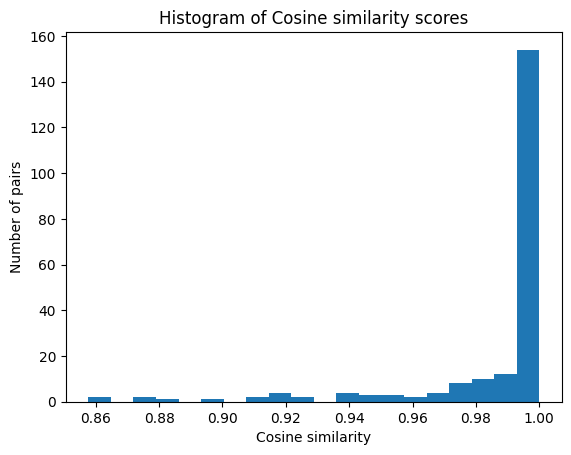

In [15]:
import matplotlib.pyplot as plt

cosine_scores = [score for (_, _, score) in cosine_pairs]
plt.hist(cosine_scores, bins=20)
plt.xlabel('Cosine similarity')
plt.ylabel('Number of pairs')
plt.title('Histogram of Cosine similarity scores')
plt.show()
